In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from random import random

In [2]:
np.array(1)

array(1)

In [3]:
import os

In [4]:
from lcmcmc.utils import get_data_dir_path

# Load data

In [5]:
new_object_df = pd.read_csv(os.path.join(get_data_dir_path(), "perfect_sims.csv"))

The perfect simulations are simulated for LSST so they have 6 differnet bands. Since right now we run the tests on the ZTF data which has only the g and r bands, we will use only these 2 from LSST for compution

# RUN MCMC

In [6]:
from lcmcmc.model import jd_model
import jax.numpy as jnp
import jax
import tensorflow_probability.substrates.jax as tfp

2023-06-12 14:36:49.238774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
rng = jax.random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:
new_object_df=new_object_df[new_object_df["object_index"]<10]

In [9]:
index = np.zeros((len(new_object_df), 2), dtype=np.int32)

index[:, 0] = np.asarray(new_object_df["object_index"].values)
index[:, 1] = np.asarray(new_object_df["band_index"].values)

x_range = jnp.asarray(new_object_df["time"])

observed_value = np.array(new_object_df["flux"].values, dtype=jnp.float32)
observed_sigma = np.array(new_object_df["fluxerr"].values, dtype=jnp.float32)

jd = jd_model(index, x_range)

In [10]:
observed_value

array([0.4338666 , 0.96490985, 0.4263303 , 1.        , 0.38786063,
       0.97899735, 0.31943357, 0.89890164, 0.25921145, 0.8177818 ,
       0.36511898, 0.88020825, 0.3703696 , 1.        , 0.27172378,
       0.91136307, 0.1794439 , 0.72990286, 0.11455161, 0.5226131 ,
       0.49266395, 0.92632014, 0.4665715 , 1.        , 0.33484071,
       0.86454237, 0.19074745, 0.59107816, 0.07811499, 0.36456198,
       0.18278731, 0.2865716 , 0.48010543, 1.        , 0.138143  ,
       0.45835465, 0.02084289, 0.12311858, 0.00313967, 0.03121912,
       1.520583  , 0.56444687, 1.523171  , 1.        , 0.98262423,
       0.876085  , 0.701762  , 0.699543  , 0.52323425, 0.52389693,
       0.12427784, 0.5121048 , 0.296865  , 1.        , 0.2631848 ,
       0.8665152 , 0.2040332 , 0.6469805 , 0.1185028 , 0.46584767,
       0.11414415, 0.89852947, 0.145011  , 1.        , 0.12702394,
       0.7468174 , 0.08809756, 0.5217693 , 0.04335927, 0.26526377,
       0.67023563, 0.8861075 , 0.70852375, 1.        , 0.58842

In [11]:
observed_sigma

array([0.01002142, 0.01151767, 0.00999857, 0.01160975, 0.00988113,
       0.01155473, 0.00966872, 0.01134244, 0.00947783, 0.0111233 ,
       0.00195962, 0.0027713 , 0.00196958, 0.00292799, 0.00177309,
       0.00281289, 0.00156713, 0.00256116, 0.00140432, 0.00223924,
       0.00571973, 0.00675878, 0.00565112, 0.00691983, 0.00529117,
       0.00662073, 0.00486706, 0.00597141, 0.00450785, 0.00537449,
       0.00158831, 0.00181808, 0.00218288, 0.00294716, 0.00147853,
       0.00214498, 0.0011408 , 0.0014397 , 0.0010807 , 0.0011746 ,
       0.00703585, 0.0051002 , 0.00704036, 0.00605913, 0.0060238 ,
       0.00580246, 0.00542086, 0.00541582, 0.00499995, 0.00500157,
       0.00724302, 0.00843231, 0.0077947 , 0.00972402, 0.00769015,
       0.00938829, 0.007503  , 0.00880836, 0.00722383, 0.00829941,
       0.01715704, 0.01967344, 0.017263  , 0.01997583, 0.01720134,
       0.01921246, 0.01706712, 0.0185075 , 0.01691155, 0.01766974,
       0.00144553, 0.00164596, 0.00148306, 0.00174244, 0.00136

In [12]:
# Run the mcmc
run_mcmc = lambda seed: tfp.experimental.mcmc.windowed_adaptive_nuts(
        100, 
        jd, 
        n_chains=4, 
        #num_adaptation_steps=5, 
        seed=seed,
        sigma=observed_sigma, 
        obs=observed_value,
    )


rng, sample_rng = jax.random.split(rng, 2)
mcmc_samples, sampler_stats = run_mcmc(sample_rng)

In [13]:
from lcmcmc.parametric_fits import parametric_fn
import matplotlib.pyplot as plt

(array([ 903., 1486.,  738., 1740., 1312., 1001.,   66.,  144.,  208.,
         402.]),
 array([ 1.65023577,  2.73092628,  3.8116169 ,  4.89230728,  5.97299767,
         7.05368853,  8.13437843,  9.21506977, 10.29576015, 11.37645054,
        12.45714092]),
 <BarContainer object of 10 artists>)

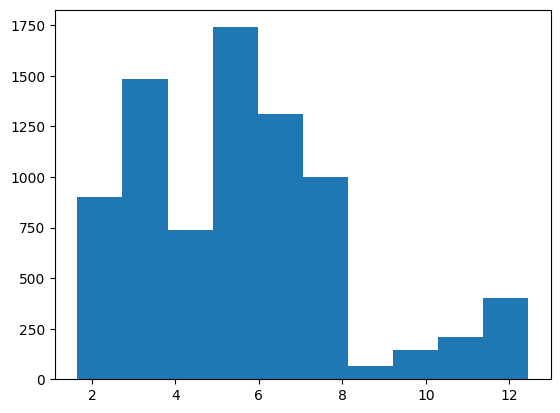

In [14]:
plt.hist(mcmc_samples.t_rise.flatten())

(array([ 876.,  579., 1313., 1546.,  480.,  800.,  790.,  495.,  330.,
         791.]),
 array([ 1.55109143,  2.64481163,  3.73853207,  4.8322525 ,  5.92597294,
         7.0196929 ,  8.11341286,  9.20713329, 10.30085373, 11.39457417,
        12.4882946 ]),
 <BarContainer object of 10 artists>)

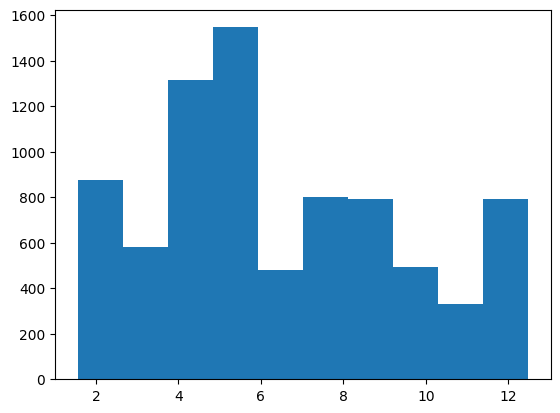

In [15]:
plt.hist(mcmc_samples.t_fall_.flatten())

In [16]:
len(mcmc_samples.t_fall_.flatten())

8000

0


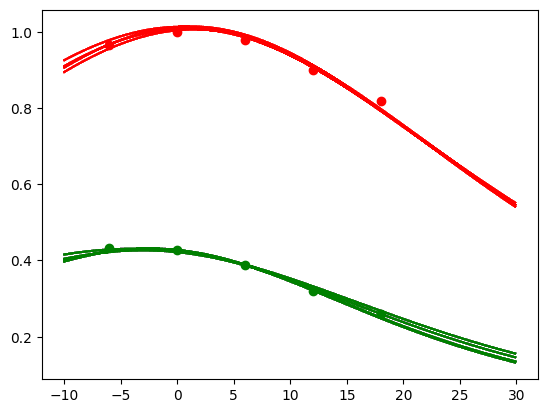

1


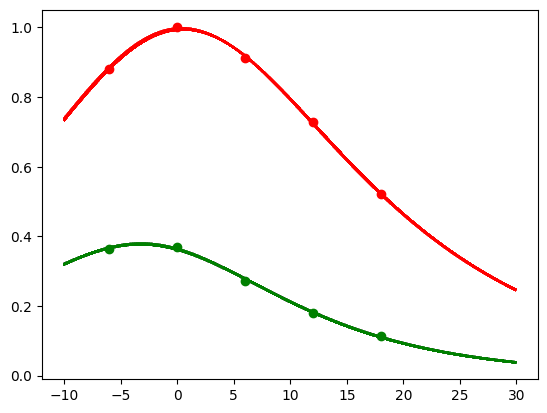

2


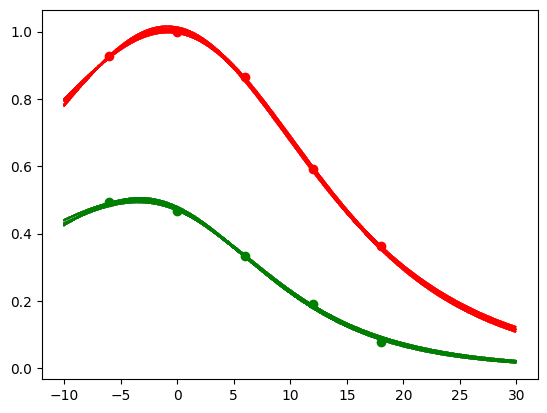

3


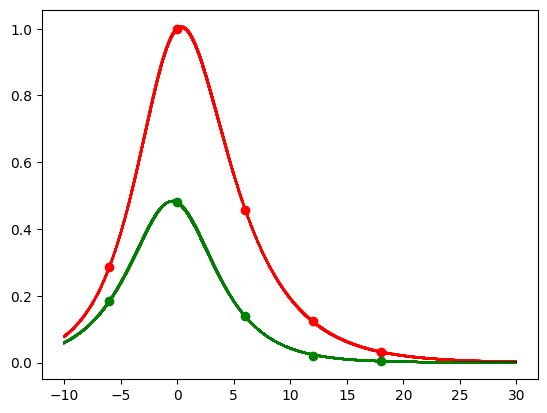

4


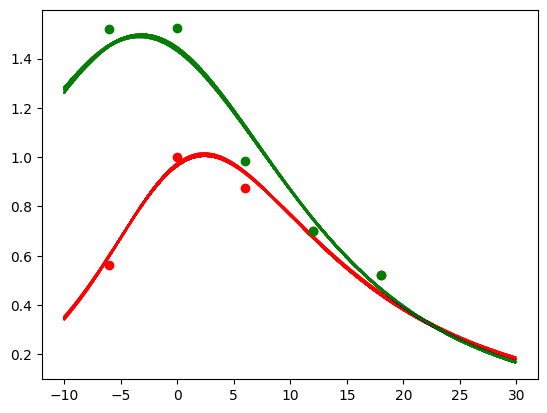

5


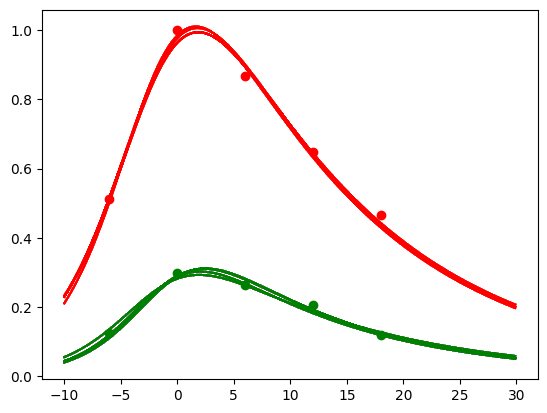

6


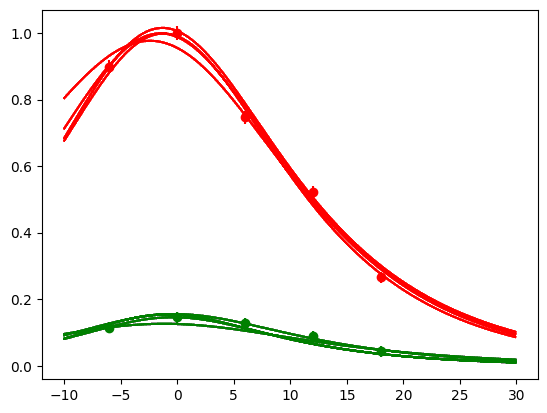

7


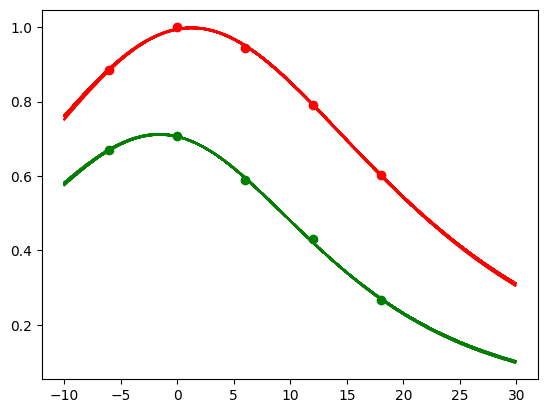

8


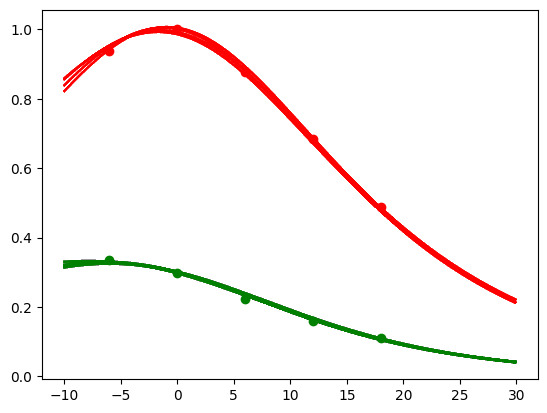

9


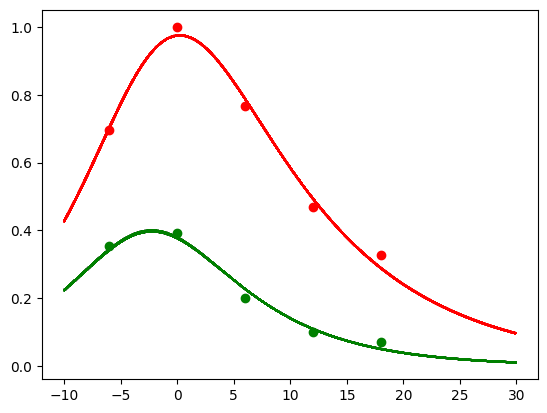

10


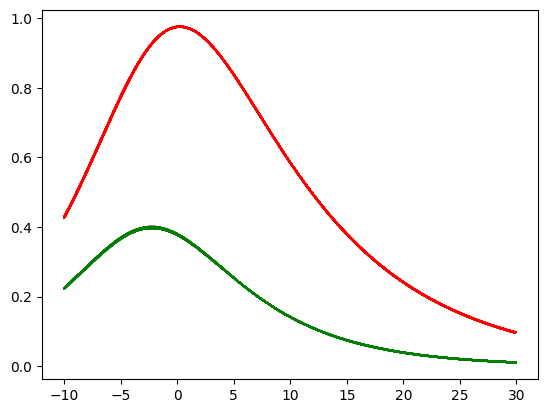

11


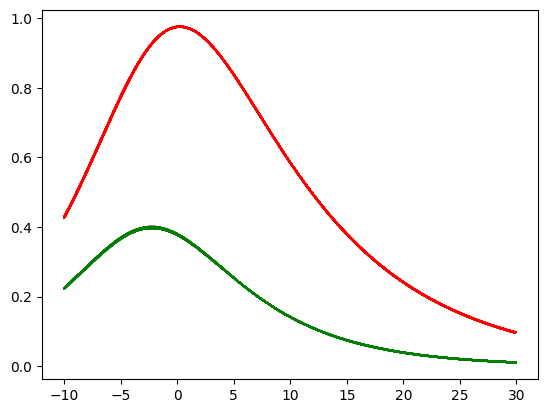

12


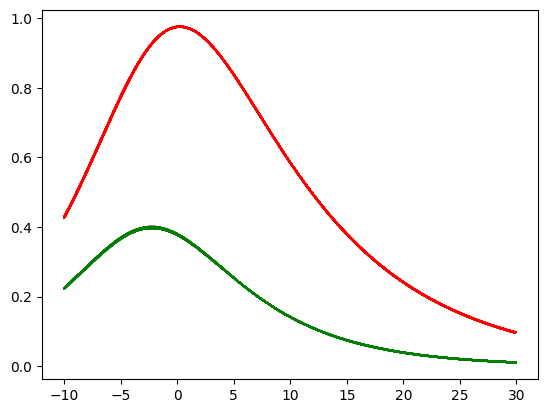

13


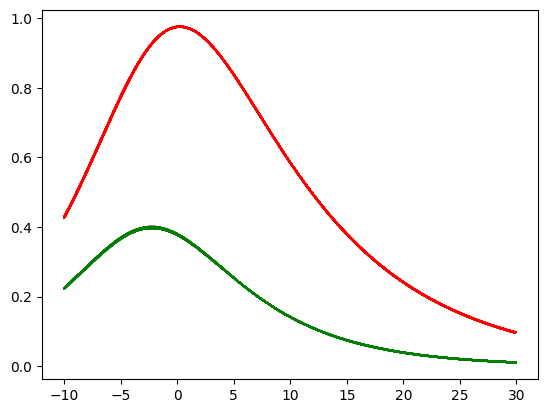

14


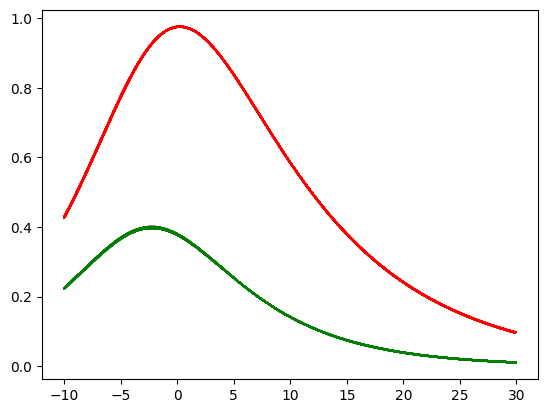

15


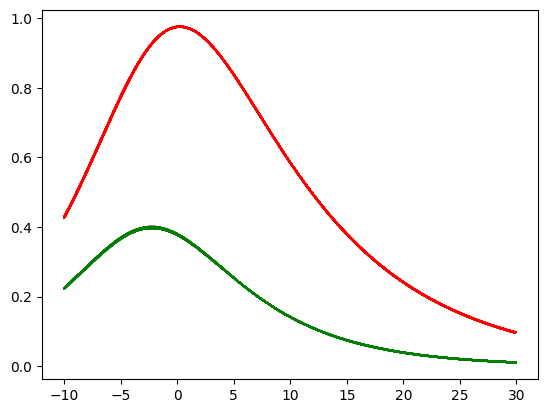

16


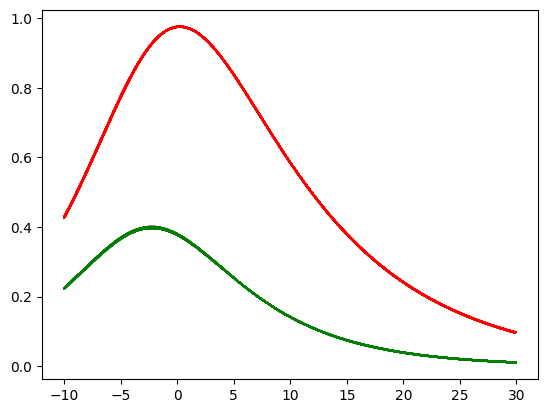

17


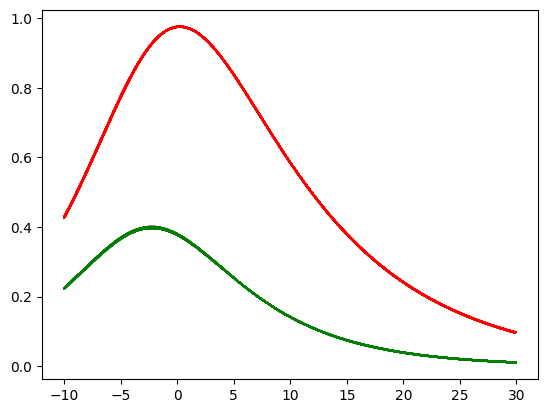

18


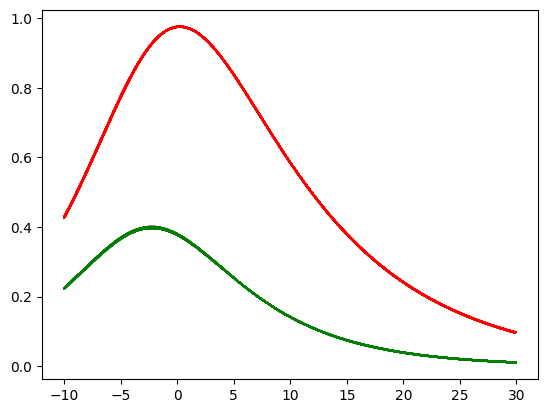

19


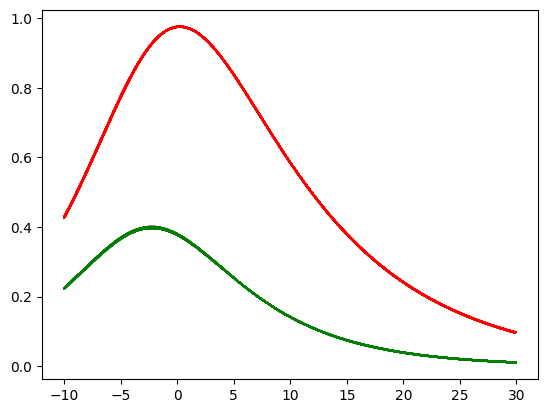

20


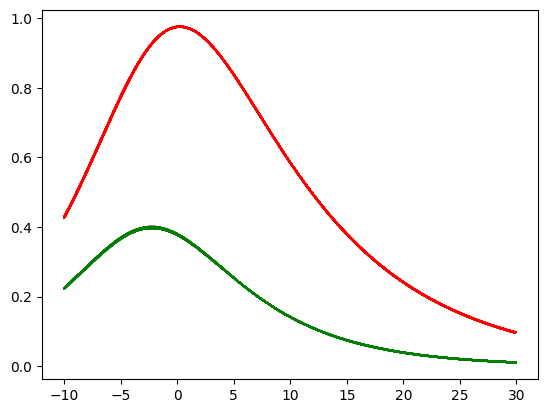

In [17]:
colors = ['r', 'g']
for event_num in range(len(index)):
    print(event_num)
    plt.figure()
    object_df = new_object_df[new_object_df['object_index']==event_num]
    for band in range(2):
        for sample_no in range(100):
            sample_no=sample_no+200
            for chain_num in range(4):
                t0 = mcmc_samples.t0[sample_no, chain_num, event_num, band]
                t_rise = mcmc_samples.t_rise[sample_no, chain_num, event_num, band]
                t_fall_ = mcmc_samples.t_fall_[sample_no, chain_num, event_num, band]
                t_fall = t_fall_ + t_rise
                amp = mcmc_samples.amp[sample_no, chain_num, event_num, band]

                predictions = parametric_fn(t0, t_rise, t_fall, amp, np.arange(-10,30, .1))
                plt.plot(np.arange(-10,30, .1), predictions, alpha=.03, color=colors[band])


        band_df = object_df[object_df['band_index']==band]
        plt.errorbar(band_df["time"], band_df["flux"], yerr=band_df["fluxerr"], fmt="o", color=colors[band])
    if event_num==20:
        break
    plt.show()